# Record Linkage Adapted from [here](https://github.com/CSSIP-AIR/Big-Data-Workbooks/blob/master/08.%20Data%20Linkage/Record%20Linkage.ipynb)

---

## Introduction

The goal of record linkage is to determine if pairs of records describe the same identity. This is important for removing duplicates from a data source or joining two separate data sources together. Record linkage also goes by the terms data matching, merge/purge, duplication detection, de-duping, reference matching, co-reference/anaphora in various fields. There are several approaches to record linkage that include exact matching, rule-based linking and probabilistic linking. An example of exact matching is joining records based on social security number. Rule-based matching involves applying a cascading set of rules that relect the domain knowledge of the records being linked. In probabilistic record linkage, linkage weights are calculated based on records and a threshold is applied to make a decision of whether to link records or not. This tutorial will cover preprocessing data, rule-based linkage and probabilitic linkage using the Felligi-Sunter model. 

## Table of Contents

1. [Load the data](#Load-the-Data)
2. [Explore the data](#Data-Exploration)
3. [Preprocess the Data](#Preprocess:-clean-Up-Names-and-separate-to-first-middle-and-last-name)
4. [Explore Metrics](#String-Comparators)
5. [Create Rule-Based Linking](#Create-A-Rule-Based-System-for-record-matching.)
6. [Create Probabilistic Liking Using Felligi Sunter](#Probabilisic-Record-Linkage)

In [1]:
%pylab inline
from __future__ import print_function
from six.moves import zip, range
import pandas as pd
import jellyfish
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


# Load the Data 

Our first dataset is all nsf grants awarded between 2010-2012

In [2]:
df_nsf_awards = pd.read_csv('./Datasets/nsf_awards_2010-2012.csv')

In [3]:
df_nsf_awards.head()

,AwardId,FirstName,LastName,StartDate,EndDate,AwardTitle,AwardEffectiveDate,AwardExpirationDate,Name,CityName,ZipCode,PhoneNumber,StreetAddress,CountryName,StateName,StateCode
0,415302,Jeffrey,Kuhn,2010-01-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
1,415302,Robert,Rosner,2010-01-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
2,415302,Philip,Goode,2010-01-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
3,415302,Thomas,Rimmele,2012-03-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
4,415302,Stephen,Keil,2010-01-15,2012-03-15,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC


Our second dataset is a list of all employees in the UC System in 2011. 

In [4]:
df_ucpay = pd.read_csv('./Datasets/ucpay2011.csv', sep='\t')

In [5]:
df_ucpay.head()

,ID,year,campus,name,title,gross,base,overtime,extra,exclude
0,1751971,2011,BERKELEY,***********,TUTOR - NON-GSHIP,0.49,0.0,0.0,0,0
1,1758984,2011,BERKELEY,***********,TUTOR - NON-GSHIP,0.49,0.0,0.0,0,0
2,1821585,2011,IRVINE,***********,TUTOR - NON-GSHIP,0.51,0.0,0.0,0,0
3,1966846,2011,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III,0.62,0.0,0.0,0,0
4,1758947,2011,BERKELEY,***********,READER - NON-GSHIP,0.73,0.0,0.0,0,0


We can see there are some redacted names from the data. Let's do some exploratory analysis on the data 

# Data Exploration

In [6]:
df_ucpay.year.unique()

array([2011])

as we expected all employees are from 2011

In [7]:
df_ucpay.campus.unique()

array(['BERKELEY', 'IRVINE', 'SAN FRANCISCO', 'LOS ANGELES', 'DANR',
       'SANTA BARBARA', 'SANTA CRUZ', 'RIVERSIDE', 'DAVIS', 'MERCED',
       'SAN DIEGO', 'UCOP'], dtype=object)

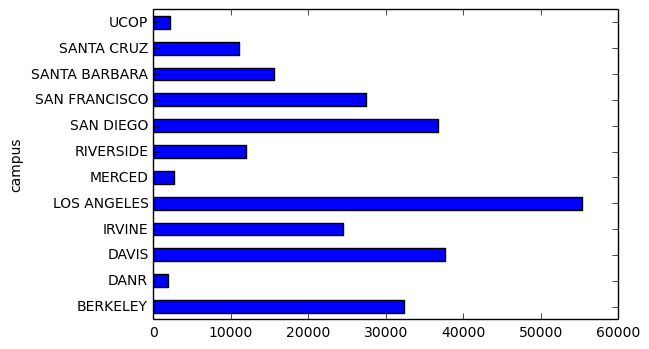

In [8]:
df_ucpay.groupby('campus').size().plot(kind='barh')

In [9]:
df_ucpay.title.unique()

array(['TUTOR - NON-GSHIP', 'STAFF RESEARCH ASSOC III',
       'READER - NON-GSHIP', ..., 'ATHLETICS MANAGER 4',
       'CHIEF EXEC OFFICER - MED CENTR', 'TREASURER OF THE REGENTS'], dtype=object)

In [10]:
len(df_ucpay.title.unique())

2626

We can see that there are 2626 unique positions in the System. It is likely only a very small subset received grants from the NSF. Typically with the title of Professor, Postdoc, Research Professional etc. 

In [11]:
df_ucpay.shape

(259043, 10)

remove all the redeacted names from the UC dataset 

In [12]:
mask = df_ucpay.name != "***********"

In [13]:
df_ucpay[mask].shape

(163429, 10)

In [14]:
df_ucpay = df_ucpay[mask]

In [15]:
df_ucpay.head(15)

,ID,year,campus,name,title,gross,base,overtime,extra,exclude
3,1966846,2011,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III,0.62,0.00,0.0,0,0
6,1870390,2011,LOS ANGELES,"ESCUJURI , ERIC JOSEPH","TECHNICIAN, SCENE, SR",1.14,0.00,0.0,0,0
7,1771936,2011,BERKELEY,"JUNG , WOO YONG",POSTDOC-EMPLOYEE,1.28,1.28,0.0,0,0
8,1892122,2011,LOS ANGELES,"SHAPIRO , JORDAN ISAAC","TECHNICIAN, SCENE",1.33,0.00,0.0,0,0
12,1988359,2011,SANTA BARBARA,"CUTLER , CHARLES IAN",LABORATORY ASST I,1.55,0.00,0.0,0,0
15,1861869,2011,LOS ANGELES,"ANDERSON , MARK CALVIN","TECHNICIAN, SCENE, SR",1.83,0.00,0.0,0,0
25,1887191,2011,LOS ANGELES,"PATEL , DEV KAPIL",ASSISTANT IV,2.19,2.19,0.0,0,0
26,1875426,2011,LOS ANGELES,"HILDER , JAMIE L",POSTDOC-EMPLOYEE,2.20,2.20,0.0,0,0
46,1977209,2011,SAN FRANCISCO,"WU , YALEI",POSTDOC-EMPLOYEE,2.84,2.84,0.0,0,0
73,1895865,2011,LOS ANGELES,"VALERIO , STEVEN GERARD,JR","TECHNICIAN, SCENE",4.24,0.00,0.0,0,0


we filtered out all the redacted names and can see the name field in the uc data is given in *lastname*, *firstname* *middle* format 

In [16]:
sel_cols = ['ID','campus', 'name', 'title']
df_ucpay = df_ucpay[sel_cols]

In [17]:
df_ucpay.head()

,ID,campus,name,title
3,1966846,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III
6,1870390,LOS ANGELES,"ESCUJURI , ERIC JOSEPH","TECHNICIAN, SCENE, SR"
7,1771936,BERKELEY,"JUNG , WOO YONG",POSTDOC-EMPLOYEE
8,1892122,LOS ANGELES,"SHAPIRO , JORDAN ISAAC","TECHNICIAN, SCENE"
12,1988359,SANTA BARBARA,"CUTLER , CHARLES IAN",LABORATORY ASST I


filter the nsf data to only display awards from CA

In [18]:
state_mask = df_nsf_awards['StateCode'] == 'CA'
df_nsf_awards = df_nsf_awards[state_mask]

In [19]:
df_nsf_awards.head()

,AwardId,FirstName,LastName,StartDate,EndDate,AwardTitle,AwardEffectiveDate,AwardExpirationDate,Name,CityName,ZipCode,PhoneNumber,StreetAddress,CountryName,StateName,StateCode
17,805989,Albert,Schwarz,2010-08-26,NaN,Application of methods of arithmetic geometry ...,2010-09-01,2014-08-31,University of California-Davis,Davis,95618-0000,5.307548e+09,OR/Sponsored Programs,United States,California,CA
40,820047,Frans,Tax,2011-03-28,NaN,Arabidopsis 2010: Global Analysis of Translati...,2009-03-01,2013-02-28,University of California-Riverside,RIVERSIDE,92521-1000,9.518276e+09,Office of Research,United States,California,CA
49,825254,Paul,Davis,2012-01-27,NaN,Collaborative Research: A 3D Seismic Study of ...,2010-01-01,2013-09-30,University of California-Los Angeles,LOS ANGELES,90095-2000,3.107940e+09,"11000 Kinross Avenue, Suite 211",United States,California,CA
53,830228,Nicholas,Melosh,2011-08-06,NaN,NSEC: CENTER FOR PROBING THE NANOSCALE,2009-09-01,2014-08-31,Stanford University,Palo Alto,94304-1212,6.507232e+09,3160 Porter Drive,United States,California,CA
58,831132,Joseph,Pasquale,2010-04-12,NaN,Collaborative Research; CT-M: Computer Systems...,2009-03-01,2012-12-31,University of California-San Diego,La Jolla,92093-0934,8.585345e+09,Office of Contract & Grant Admin,United States,California,CA


# What kind of the records do we want to match

Given the name of an award match their record with the UC database to get their position and employee id. 

# Preprocess: clean Up Names and separate to first middle and last name

In [20]:
names = df_ucpay.name.values

In [21]:
def split_names(name):
    """
    Splits names fields into first, middle and last names
    and return lower case values. 
    
    Parameters
    -----------
    name: str
        e.g., SHAPIRO, JORDAN ISAAC
    
    
    Returns
    -------
    (first, middle, last): str
        e.g., mark calvin anderson
    """
    
    #split on the comma do get the last name
    name=name.lower()
    ls_name = name.split(',')

    last_name = ls_name[0]
    first_middle_name = ls_name[1]
    
    #split by space to get the first and middle name
    ls_first_middle_name = first_middle_name.split()
    if len(ls_first_middle_name) > 1:
        first_name = ls_first_middle_name[0]
        middle_name = ls_first_middle_name[1]
    else: 
        first_name = ls_first_middle_name[0]
        middle_name = ''
    return unicode(first_name.strip()), unicode(middle_name.strip()), unicode(last_name.strip())

In [22]:
ls_cleaned_names = [split_names(name) for name in names]

In [23]:
ls_first, ls_middle, ls_last = zip(*ls_cleaned_names)

In [24]:
df_ucpay['first'] = ls_first
df_ucpay['middle'] = ls_middle
df_ucpay['last'] = ls_last

In [25]:
df_ucpay.head()

,ID,campus,name,title,first,middle,last
3,1966846,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III,carl,e,mackewicz
6,1870390,LOS ANGELES,"ESCUJURI , ERIC JOSEPH","TECHNICIAN, SCENE, SR",eric,joseph,escujuri
7,1771936,BERKELEY,"JUNG , WOO YONG",POSTDOC-EMPLOYEE,woo,yong,jung
8,1892122,LOS ANGELES,"SHAPIRO , JORDAN ISAAC","TECHNICIAN, SCENE",jordan,isaac,shapiro
12,1988359,SANTA BARBARA,"CUTLER , CHARLES IAN",LABORATORY ASST I,charles,ian,cutler


we know have cleaned fields for the first, middle and last names. The NSF data only has first and last name fields so we only need the first and last name fields. 

In [26]:
df_nsf_awards.dropna(subset=['FirstName','LastName'], inplace=True)

drop any rows that do not have entries in the FirstName and LastName field

In [27]:
df_nsf_awards['first'] = [unicode(name.lower()) for name in df_nsf_awards['FirstName'].values]
df_nsf_awards['last'] = [unicode(name.lower()) for name in df_nsf_awards['LastName'].values]

>**Note**: In python2 we have to explicitly tell Python we want a string to be encoding in unicode. In Python3 all strings 
>are by default unicode. 


In [28]:
df_nsf_awards.head()

,AwardId,FirstName,LastName,StartDate,EndDate,AwardTitle,AwardEffectiveDate,AwardExpirationDate,Name,CityName,ZipCode,PhoneNumber,StreetAddress,CountryName,StateName,StateCode,first,last
17,805989,Albert,Schwarz,2010-08-26,NaN,Application of methods of arithmetic geometry ...,2010-09-01,2014-08-31,University of California-Davis,Davis,95618-0000,5.307548e+09,OR/Sponsored Programs,United States,California,CA,albert,schwarz
40,820047,Frans,Tax,2011-03-28,NaN,Arabidopsis 2010: Global Analysis of Translati...,2009-03-01,2013-02-28,University of California-Riverside,RIVERSIDE,92521-1000,9.518276e+09,Office of Research,United States,California,CA,frans,tax
49,825254,Paul,Davis,2012-01-27,NaN,Collaborative Research: A 3D Seismic Study of ...,2010-01-01,2013-09-30,University of California-Los Angeles,LOS ANGELES,90095-2000,3.107940e+09,"11000 Kinross Avenue, Suite 211",United States,California,CA,paul,davis
53,830228,Nicholas,Melosh,2011-08-06,NaN,NSEC: CENTER FOR PROBING THE NANOSCALE,2009-09-01,2014-08-31,Stanford University,Palo Alto,94304-1212,6.507232e+09,3160 Porter Drive,United States,California,CA,nicholas,melosh
58,831132,Joseph,Pasquale,2010-04-12,NaN,Collaborative Research; CT-M: Computer Systems...,2009-03-01,2012-12-31,University of California-San Diego,La Jolla,92093-0934,8.585345e+09,Office of Contract & Grant Admin,United States,California,CA,joseph,pasquale


# String Comparators

Now that we have cleaned data lets explore how to match the string fields. For continuous fields, comparision is simple, the absolute difference between the values can be taken as a measure of the closeness. For string comparisions it is a little bit more complex. One metric is the *edit distance*, the minimum number of edit distances to transform one string to another. In the case of how many insertions, deletions and substitutions to transform one string to antoher that is known as the *Levenshtein distance*. If you add transposing with adjacent letters that is known as the *Levenshtein-Damerau distance*. The *Jaro-Winkler* distance is a fast-to-compute distance metric that returns a normalized score between zero and one. 

In [29]:
class StringComparators():
    """
    Test various string comparators 
    """

    def test_levenshtein_distance():
        assert jellyfish.levenshtein_distance('John', 'John') == 0
        assert jellyfish.levenshtein_distance('Jon', "John") == 2
        assert jellyfish.levenshtein_distance('Joseph', 'Joesph') == 1
        
    def test_damerau_levenshtein():
        assert jellyfish.damerau_levenshtein_distance('Joseph', 'Joesph') == 1

    def test_jaro_winklear():
        assert (np.isclose(jellyfish.jaro_winkler('Joseph', 'Joesph'), 0.955555))
        assert (np.isclose(jellyfish.jaro_winkler('Chris', 'Christoper'), 0.9))

# Lets get the to 10 matching first names in the nsf database according to the jaro-winker score 

In [30]:
uniq_nsf_firstname = set( df_nsf_awards['first'].values ) #grab unique names from the nsf

In [31]:
uc_names = df_ucpay['first'].values #grab the uc_names

In [32]:
# Comparison of records

In [33]:
testname = unicode(uc_names[0])

In [34]:
def get_matching_first_name(testname, NUM_NAMES=10):
    """
    get top 10 first names that match
    """
    dict_name_pair = {}
    for name in uc_names:
        name = unicode(name)
        dist = jellyfish.jaro_winkler(testname,name)
        dict_name_pair[name] = dist

    orddict_dict_name_pair = OrderedDict(
                                sorted(dict_name_pair.items(), key=lambda x: x[1]))

    ls_sorted_name = list(orddict_dict_name_pair.keys())


    return ls_sorted_name[-NUM_NAMES:][::-1]

In [35]:
print(testname,get_matching_first_name(testname))

carl ['carl', 'carlo', 'carly', 'carli', 'carla', 'caryl', 'carol', 'carlen', 'carlin', 'carlie']


In [36]:
for nm in uc_names[:25]:
    testname = unicode(nm)
    print(testname, get_matching_first_name(testname))

carl ['carl', 'carlo', 'carly', 'carli', 'carla', 'caryl', 'carol', 'carlen', 'carlin', 'carlie']
eric ['eric', 'erick', 'erica', 'erich', 'erice', 'erric', 'enric', 'edric', 'ericha', 'ericka']
woo ['woo', 'wook', 'wood', 'woon', 'wo', 'woody', 'woori', 'elwood', 'witoon', 'woodrow']
jordan ['jordan', 'jordane', 'jordana', 'jourdan', 'jordon', 'jordaniel', 'jordin', 'jodean', 'joan', 'joraine']
charles ['charles', 'charless', 'charley', 'charlee', 'charese', 'charlie', 'charleston', 'charlane', 'charleen', 'charlene']
mark ['mark', 'marka', 'marko', 'marek', 'markus', 'markos', 'markle', 'markim', 'markee', 'maryke']
dev ['dev', 'deva', 'devi', 'de', 'devra', 'devyn', 'devie', 'devon', 'devin', 'devan']
jamie ['jamie', 'jamiel', 'jammie', 'jami', 'jaymie', 'jaime', 'jamaine', 'amie', 'jasmine', 'jazmine']
yalei ['yalei', 'yale', 'yanlei', 'yali', 'yaneli', 'yawei', 'yanli', 'yafei', 'yael', 'maylei']
steven ['steven', 'steaven', 'steve', 'stevon', 'stevan', 'stevie', 'sten', 'steven-h

# Create A Rule Based System for record matching. 

Let's try to merge data with the following rules. 

1. The first name Jaro-Winkler score has to be greater than 0.90
2. The last name Jaro-Winkler score has to be greater then 0.90

This rule essentially means that the names have to match with very minor typos. 


In [37]:
dict_nsf_awards = df_nsf_awards[:10].to_dict(orient='index')

In [38]:
def create_rule_mask(nsf_first_name, 
                     nsf_last_name,
                     df_ucpay,
                     first_name_thresh=0.90,
                     last_name_thresh=0.90):
    """
    Returns a boolean array of records to match based on a
    fixed threshold. 
    
    Parameters
    ----------
    (nsf_first_name, nsf_last_name): str
        first and last name in the NSF dataset
        
    df_ucpay: DataFrame
        DataFrame of the UC directory
        
    (first_name_thresh,last_name_thresh): int
        
        
    Returns
    -------
    jaro_mask: ls[bool]
        boolean list of records to match
    """
    compare_first = lambda x: jellyfish.jaro_winkler(nsf_first_name,x)
    compare_last = lambda x: jellyfish.jaro_winkler(nsf_last_name,x)

    jaro_first = df_ucpay['first'].map(compare_first) 
    jaro_last = df_ucpay['last'].map(compare_last)

    jaro_mask = (jaro_first > first_name_thresh) & (jaro_last > last_name_thresh)
    
    return jaro_mask
    

In [39]:
def match_records(dict_nsf_awards, df_ucpay, f_create_rule_mask):
    """
    match records from the nsf and uc datasets based on the fields 'first' and 'last' name
    
    Parameters
    ---------
    dict_nsf_awards: dict
        dictionary of nsf awards
    df_ucpay: DataFrame
        DataFrame of UC employees
    create_rule_mask: function
        Function that takes a first name, last name and df_ucpay
        and returns a Boolean array of whether or not to match 
        records
    
    Returns
    -------
    df_linked_data: DataFrame
    """
    
    df_linked_data = pd.DataFrame()
    for key in dict_nsf_awards.keys():
        dict_test_row = dict_nsf_awards[key]
    
        nsf_first_name = dict_test_row['first']
        nsf_last_name = dict_test_row['last']

        jaro_mask = f_create_rule_mask(nsf_first_name, nsf_last_name, df_ucpay)
    
        df_matches = df_ucpay[jaro_mask]
        if len(df_matches) == 0:
            print('No Match: {} {}'.format(nsf_first_name,nsf_last_name))
        for row in df_matches.iterrows():
            dict_test_row['ID'] = row[1]['ID']
            dict_test_row['campus'] = row[1]['campus']
            dict_test_row['name'] = row[1]['name']
            dict_test_row['title'] = row[1]['title']
            df_linked_data = df_linked_data.append(dict_test_row, ignore_index=True)
            
    return df_linked_data

In [40]:
df_linked_data = match_records(dict_nsf_awards, df_ucpay, create_rule_mask )

No Match: nicholas melosh
No Match: frans tax
No Match: craig heinselman
No Match: mary mccready


In [41]:
sel_col = ['AwardId', 'CityName', 'FirstName', 'ID', 'LastName', 'Name', 'campus', 'title', 'first', 'last']
df_linked_data[sel_col]

,AwardId,CityName,FirstName,ID,LastName,Name,campus,title,first,last
0,805989.0,Davis,Albert,1814365.0,Schwarz,University of California-Davis,DAVIS,PROFESSOR - ACADEMIC YEAR,albert,schwarz
1,838258.0,BERKELEY,Leo,1765982.0,Blitz,University of California-Berkeley,BERKELEY,PROFESSOR - ACADEMIC YEAR,leo,blitz
2,825254.0,LOS ANGELES,Paul,1832316.0,Davis,University of California-Los Angeles,IRVINE,"ANALYST, ADMINISTRATIVE, ASST",paul,davis
3,825254.0,LOS ANGELES,Paul,1832352.0,Davis,University of California-Los Angeles,IRVINE,HOSPITAL UNIT SERV COORD II,paul,davis
4,825254.0,LOS ANGELES,Paul,1800777.0,Davis,University of California-Los Angeles,DAVIS,RESEARCH _____ - FISCAL YEAR,paul,davis
5,825254.0,LOS ANGELES,Paul,1868502.0,Davis,University of California-Los Angeles,LOS ANGELES,PROGRAMMER/ANALYST IV - SUPERV,paul,davis
6,825254.0,LOS ANGELES,Paul,1868593.0,Davis,University of California-Los Angeles,LOS ANGELES,PROFESSOR - ACADEMIC YEAR,paul,davis
7,833340.0,SANTA CRUZ,Gretchen,1999814.0,Andreasen,University of California-Santa Cruz,SANTA CRUZ,ADMIN/COORD/OFFICER(FUNC AREA),gretchen,andreasen
8,831132.0,La Jolla,Joseph,1887173.0,Pasquale,University of California-San Diego,LOS ANGELES,"REPRESENTATIVE, ACCESS, PRIN",joseph,pasquale
9,831132.0,La Jolla,Joseph,1942864.0,Pasquale,University of California-San Diego,SAN DIEGO,PROFESSOR-ACAD YR-BUS/ECON/ENG,joseph,pasquale


As we can see 4 records in the NSF database had no matches in teh UC database. Also if we examine the output of the record linkage more closely we see we have a few false postives, Paul Davies, Joseph Pasquale.

There are several shortcomings to this approach:
    
1. There is no threshold that can be adjusted for the proper tolerance of false postives and false negatives
2. As you apply more and more rules is can become unclear what the combination of rules has on the final linkage
3. Rules also often reflect the creators domain knowledge.

# Probabilisic Record Linkage 

The Fellegi-Sunter probablistic record linkage model compares selected similiar fields in two records and calculated a weighted probablity of being similar.  The algorithm is the following: two fields are first compared using a metric, in this case, the jaro-winkler algorithm. The jaro-winkler distance is then obtained from the jaro-winkler algorithm is then binned into a category -- exact match, close match and no match. The category the comparison falls into is then weighed with two distributions. The probability that the records are a match and the probablity that the record are a non-match are then calculated for each field. The log probablity of being a match or a non-match are then combined for each field respectively. The final score is then the probablity of being a match minus the probablity of being a non-match. If the final score is greater then a thershold, then the records are considered to match.  

In [42]:
class FellegiSunter():
    """
    class to implement Fellegi Sunter model
    """
    
    m_weights = {'first_name': (0.01,0.14,0.85),
                 'last_name': (0.01,0.09,0.90)}
    
    u_weights = {'first_name': (0.88,0.10,0.02),
                 'last_name': (0.91,0.08,0.01)}
    
    
    def fuzzy_match(self,name1,name2):
        """
        Compares two strings using jaro-winker and
        outputs and returns one of three match
        levels.
        
        * exact match is a jaro-winkler score >= 0.92
        * close match is a jaro-winkler score > 0.85
        * no match is a jaro-winkler score < 0.85
        
        Parameters
        ----------
        (name1, name2): str
            two text strings to output
            
        Returns
        -------
        match_level: int
            one of three match levels
            2 - exact match 
            1 - close match
            0 - not a match
        """
        score = jellyfish.jaro_winkler(name1,name2)
        if score >= 0.92:
            return 2
        elif score > 0.85:
            return 1
        else:
            return 0
        
    def match_score(self,record1,record2):
        """
        computes the match score between a pair
        of records
        
        Parameters
        ----------
        (record1, record2): tuple(str)
            tuples of records to be compared
            
        Returns
        -------
        match_score: int
        
        Raises
        ------
        Exception
            tuples need to be the same size 
        """
        if not(len(record1) == len(record2)):
            raise Exception('records need to be same size')
        
        scores = [self.fuzzy_match(rec1,rec2) for rec1, rec2 in zip(record1, record2)]
        
        first_name_score, last_name_score = scores
        
        #grab the m and u weights
        
        first_name_m_weight = self.m_weights['first_name'][first_name_score]
        first_name_u_weight = self.u_weights['last_name'][first_name_score]
        
        last_name_m_weight = self.m_weights['first_name'][last_name_score]
        last_name_u_weight = self.u_weights['last_name'][last_name_score]
        
        log_prob_match = math.log(first_name_m_weight) + math.log(last_name_m_weight)
        log_prob_umatch = math.log(first_name_u_weight) + math.log(last_name_u_weight)
        
        match_score = log_prob_match - log_prob_umatch
        
        return match_score
        
    def link_record(self, record1, record2, threshold=0.5):
        """
        Returns True if records should be linked
        False otherwise.
        
        Parameters
        ----------
        (record1, record2): tuple(str)
            tuples of records to be compared. must
            be the same length
        threshold: int
            threshold for linking or not
        
        Returns
        -------
        link: bool
            bool on whether to link two records or not
        """
        
        match_score = self.match_score(record1,record2)
        if match_score > threshold:
            return True
        else:
            return False
        

In [43]:
fs = FellegiSunter()

In [44]:
print( fs.link_record(('Avishek','Kumar'), ('Avishek','Kumar')) )

True


In [45]:
print( fs.link_record( ('Avishek','Kumar'), ('Anup','Kumar') ) )

False


In [46]:
#let's take this new function for a spin
print('jonathon', 'jonthon',fs.fuzzy_match('jonathon','jonthon') )
print('john', 'mark',fs.fuzzy_match('john','mark') )
print('fred', 'frederick', fs.fuzzy_match('fred', 'frederick'))

jonathon jonthon 2
john mark 0
fred frederick 1


In [47]:
def create_jaro_mask(nsf_first_name, nsf_last_name, df_ucpay):
    """
    create a boolean array for whether to link records based on
    the jaro-winkler distance
    
    Parameters
    ----------
    (nsf_first_name, nsf_last_name): str
        first and last name in the NSF dataset
        
    df_ucpay: DataFrame
        DataFrame of the UC directory
        
    Returns
    -------
    jaro_mask: ls[bool]
        boolean list of records to match
    """
    record = (nsf_first_name, nsf_last_name)
    uc_records = df_ucpay[['first','last']].values
    
    jaro_mask = [fs.link_record(record, uc_record) for uc_record in uc_records]
    
    return jaro_mask
    
    

In [48]:
df_linked_data = match_records(dict_nsf_awards, df_ucpay, create_jaro_mask )

No Match: nicholas melosh
No Match: frans tax
No Match: craig heinselman


In [49]:
sel_col = ['AwardId', 'CityName', 'FirstName', 'ID', 'LastName', 'Name', 'campus', 'title', 'first', 'last']
df_linked_data[sel_col]

,AwardId,CityName,FirstName,ID,LastName,Name,campus,title,first,last
0,805989.0,Davis,Albert,1814365.0,Schwarz,University of California-Davis,DAVIS,PROFESSOR - ACADEMIC YEAR,albert,schwarz
1,838258.0,BERKELEY,Leo,1765982.0,Blitz,University of California-Berkeley,BERKELEY,PROFESSOR - ACADEMIC YEAR,leo,blitz
2,825254.0,LOS ANGELES,Paul,1832316.0,Davis,University of California-Los Angeles,IRVINE,"ANALYST, ADMINISTRATIVE, ASST",paul,davis
3,825254.0,LOS ANGELES,Paul,1832352.0,Davis,University of California-Los Angeles,IRVINE,HOSPITAL UNIT SERV COORD II,paul,davis
4,825254.0,LOS ANGELES,Paul,1800777.0,Davis,University of California-Los Angeles,DAVIS,RESEARCH _____ - FISCAL YEAR,paul,davis
5,825254.0,LOS ANGELES,Paul,1868502.0,Davis,University of California-Los Angeles,LOS ANGELES,PROGRAMMER/ANALYST IV - SUPERV,paul,davis
6,825254.0,LOS ANGELES,Paul,1868593.0,Davis,University of California-Los Angeles,LOS ANGELES,PROFESSOR - ACADEMIC YEAR,paul,davis
7,833340.0,SANTA CRUZ,Gretchen,1999814.0,Andreasen,University of California-Santa Cruz,SANTA CRUZ,ADMIN/COORD/OFFICER(FUNC AREA),gretchen,andreasen
8,831132.0,La Jolla,Joseph,1887173.0,Pasquale,University of California-San Diego,LOS ANGELES,"REPRESENTATIVE, ACCESS, PRIN",joseph,pasquale
9,831132.0,La Jolla,Joseph,1942864.0,Pasquale,University of California-San Diego,SAN DIEGO,PROFESSOR-ACAD YR-BUS/ECON/ENG,joseph,pasquale


Here is the matching using probablistic matching. We can change the thresholds do see how results will vary.

[Back to Table of Contents](#Table-of-Contents)